<a href="https://colab.research.google.com/github/JuanFdoGf/PracticasDS/blob/main/Predicci%C3%B3n_Temperatura_EWMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. lectura y representación del conjunto de datos

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data/weather_Madrid.csv')
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,CET,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,...,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,1997-1-1,7.0,4.0,2.0,5.0,3.0,2.0,100.0,95.0,76.0,...,10.0,9.0,4.0,13,6,NaN,0.00,6.0,NaN,229
1,1997-1-2,7.0,3.0,0.0,6.0,3.0,0.0,100.0,92.0,71.0,...,10.0,9.0,4.0,26,8,47.0,0.00,5.0,Rain,143
2,1997-1-3,5.0,3.0,2.0,5.0,1.0,-1.0,100.0,85.0,70.0,...,10.0,10.0,7.0,27,19,NaN,0.00,6.0,Rain-Snow,256
3,1997-1-4,7.0,3.0,-1.0,-2.0,-3.0,-4.0,86.0,63.0,49.0,...,10.0,10.0,10.0,27,19,40.0,0.00,2.0,NaN,284
4,1997-1-5,2.0,0.0,-1.0,2.0,0.0,-3.0,100.0,95.0,86.0,...,10.0,5.0,1.0,14,6,NaN,0.00,7.0,Snow,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6807,2015-12-27,14.0,7.0,-1.0,6.0,2.0,-2.0,100.0,77.0,30.0,...,31.0,14.0,5.0,14,6,NaN,0.00,8.0,Fog,38
6808,2015-12-28,15.0,8.0,2.0,8.0,4.0,1.0,100.0,78.0,34.0,...,31.0,14.0,8.0,27,8,45.0,0.51,7.0,Rain,243
6809,2015-12-29,11.0,8.0,5.0,9.0,7.0,5.0,100.0,89.0,66.0,...,31.0,9.0,0.0,14,8,32.0,2.03,5.0,Fog-Rain,190
6810,2015-12-30,9.0,8.0,6.0,7.0,6.0,5.0,93.0,87.0,70.0,...,19.0,10.0,6.0,14,5,34.0,0.00,6.0,NaN,256


In [2]:
# Transformamos la columna CET a formato fecha para comparar
df['CET'] = pd.to_datetime(df['CET'])

In [3]:
# Creamos el filtro que queremos aplicar al conjunto de datos
mask = (df['CET'] >= '2015-1-1') & (df['CET'] <= '2015-12-31')

In [4]:
df_prep = df.loc[mask][['CET', 'Mean TemperatureC']]
df_prep

,CET,Mean TemperatureC
6447,2015-01-01,3.0
6448,2015-01-02,3.0
6449,2015-01-03,4.0
6450,2015-01-04,7.0
6451,2015-01-05,6.0
...,...,...
6807,2015-12-27,7.0
6808,2015-12-28,8.0
6809,2015-12-29,8.0
6810,2015-12-30,8.0


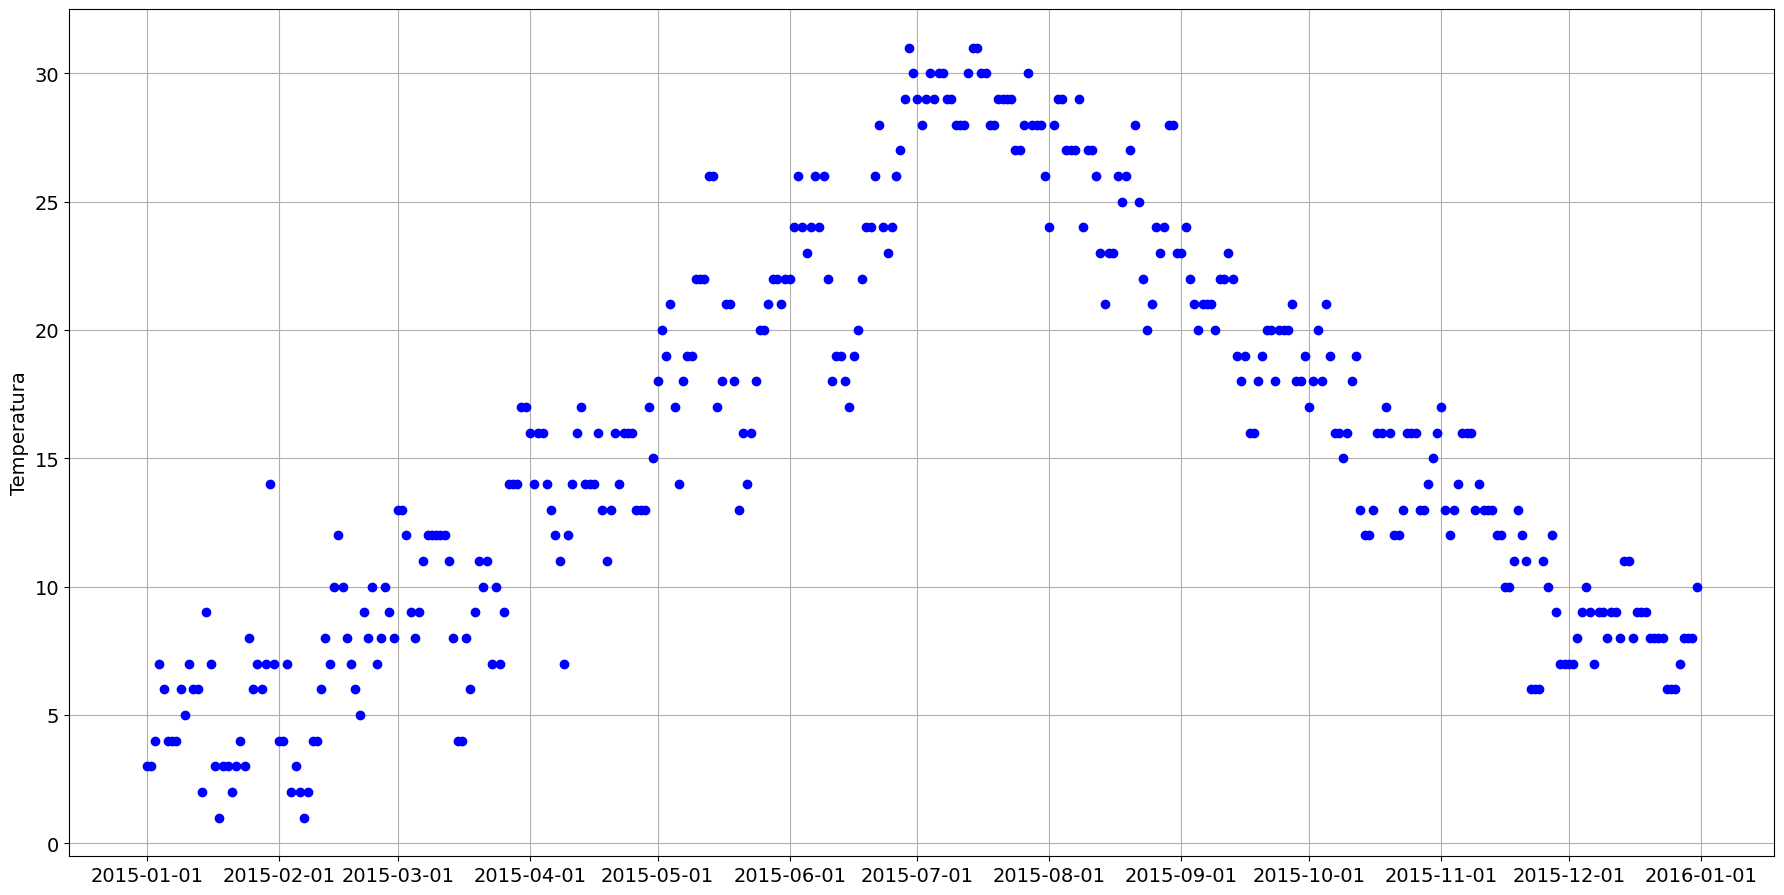

In [5]:
from ast import increment_lineno
# Representación gráfica del conjunto de datos
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.figure(figsize=(22, 11))
plt.plot(df_prep['CET'], df_prep['Mean TemperatureC'], 'bo')

plt.ylabel('Temperatura', fontsize=14)
plt.xticks(['2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2015-09',
'2015-10', '2015-11', '2015-12', '2016-01'], fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)

plt.show()

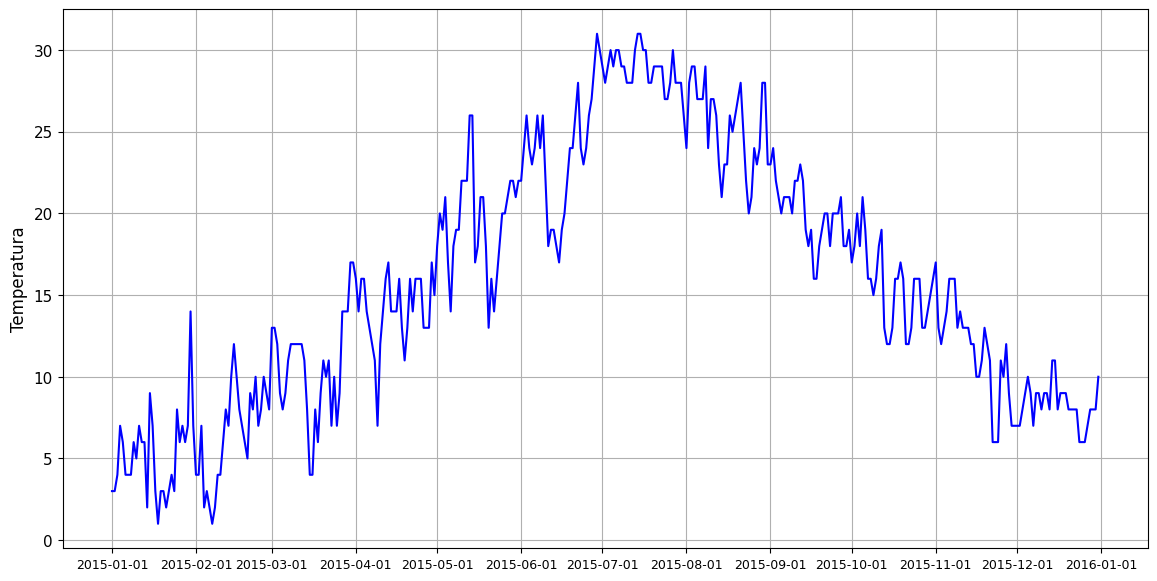

In [6]:
# Representación gráfica del conjunto de datos
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.figure(figsize=(14, 7))
plt.plot(df_prep['CET'], df_prep['Mean TemperatureC'], 'b')

plt.ylabel('Temperatura', fontsize=12)
plt.xticks(['2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2015-09',
'2015-10', '2015-11', '2015-12', '2016-01'], fontsize=9)
plt.yticks(fontsize=11)
plt.grid(True)

plt.show()

## Exponentially Weighted Moving Average

In [7]:
# Calculamos Exponentially Weighted Movig Average sobre un ejemplo
def ewma(theta, b=0.9):
    if len(theta) == 1:
        return b*0 + (1+b)*theta[-1]
    return b*ewma(theta[:-1]) + (1-b)*theta[-1]

In [8]:
import numpy as np

def apply_ewma(data, b=0.9):
    v_data = []
    for i in np.arange(1, len(data) + 1):
        print('\rProcesando ejemplo: {0}'.format(i), end='')
        v_data.append(ewma(data[:i], b=b))
    return v_data

In [9]:
v_df = apply_ewma(list(df_prep['Mean TemperatureC']))

Procesando ejemplo: 365

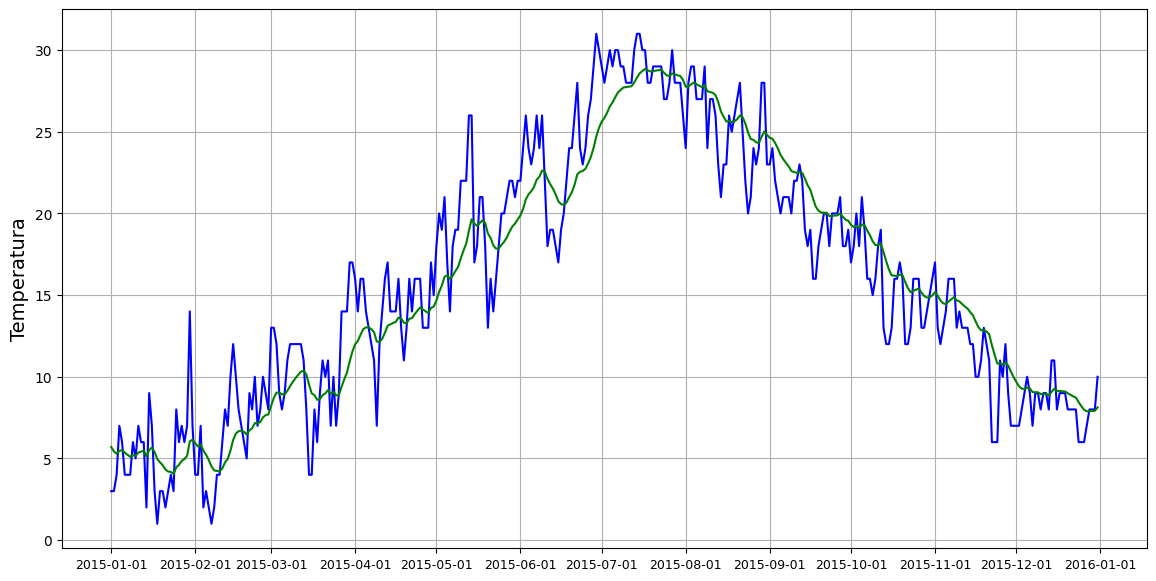

In [10]:
# Representación gráfica del conjunto de datos
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.figure(figsize=(14, 7))

plt.plot(df_prep['CET'], df_prep['Mean TemperatureC'], c='b')
plt.plot(df_prep['CET'], v_df, c='g')

plt.ylabel('Temperatura', fontsize=14)
plt.xticks(['2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2015-09',
'2015-10', '2015-11', '2015-12', '2016-01'], fontsize=9)
plt.grid(True)

plt.show()

## Exponentially Weighted Moving Average With Bias Correction

In [11]:
def ewma(theta, b=0.9):
    if len(theta) == 1:
        return b*0 + (1-b)*theta[-1]
    return b*ewma(theta[:-1]) + (1-b)*theta[-1]

In [12]:
# Aplicamos bias correction
import numpy as np

def apply_ewma_bias_corr(data, b=0.9):
    v_data = []
    for i in np.arange(1, len(data) + 1):
        print('\rProcesando ejemplo: {0}'.format(i), end='')
        v_data.append(ewma(data[:i], b=b) / (1-b**i))
    return v_data

In [13]:
v_df_corr = apply_ewma_bias_corr(list(df_prep['Mean TemperatureC']))

Procesando ejemplo: 365

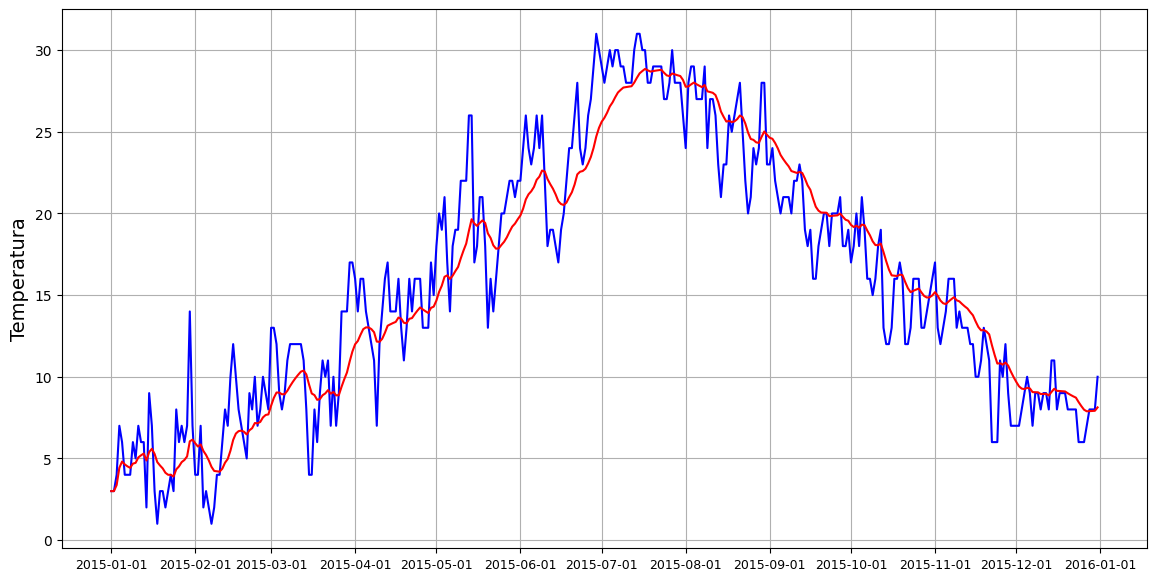

In [14]:
# Representación gráfica del conjunto de datos
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.figure(figsize=(14, 7))

plt.plot(df_prep['CET'], df_prep['Mean TemperatureC'], c='b')
plt.plot(df_prep['CET'], v_df_corr, c='r')

plt.ylabel('Temperatura', fontsize=14)
plt.xticks(['2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2015-09',
'2015-10', '2015-11', '2015-12', '2016-01'], fontsize=9)
plt.grid(True)

plt.show()